[[ 0.   19.68 17.05 19.37 23.87 22.48]
 [ 9.42  0.   11.13 13.57 18.47 16.87]
 [24.8  20.2   0.    8.97  7.73  5.98]
 [20.7  12.75  5.95  0.    4.93  5.18]
 [19.42 29.77 27.   28.23  0.   26.47]
 [20.88 13.17  6.18  3.3   5.25  0.  ]]



[[ 0.   20.52 17.22 20.3  23.83 22.52]
 [ 9.78  0.   10.88 13.92 18.02 16.55]
 [24.87 20.43  0.    9.25  7.62  5.87]
 [21.72 13.77  6.27  0.    5.03  5.28]
 [20.02 30.82 27.87 28.37  0.   25.17]
 [21.43 13.6   6.12  3.67  5.15  0.  ]]



[[ 0.   19.13 16.38 19.6  22.83 21.2 ]
 [ 9.65  0.   10.52 13.38 16.87 15.62]
 [21.28 17.32  0.    8.28  6.5   4.93]
 [20.15 12.48  5.98  0.    4.65  5.02]
 [18.42 28.38 25.7  25.1   0.   21.7 ]
 [19.92 12.17  5.5   3.35  4.58  0.  ]]



[[ 0.   19.07 16.22 19.43 22.65 21.02]
 [ 9.5   0.   10.7  13.87 17.08 15.72]
 [19.93 16.42  0.    8.27  6.72  5.1 ]
 [20.58 13.17  6.55  0.    4.72  4.93]
 [17.67 27.93 24.72 24.62  0.   21.05]
 [20.17 12.85  6.1   3.33  4.8   0.  ]]



[[   0. 3448. 3279. 3779. 4910. 4623.]
 [2219.  

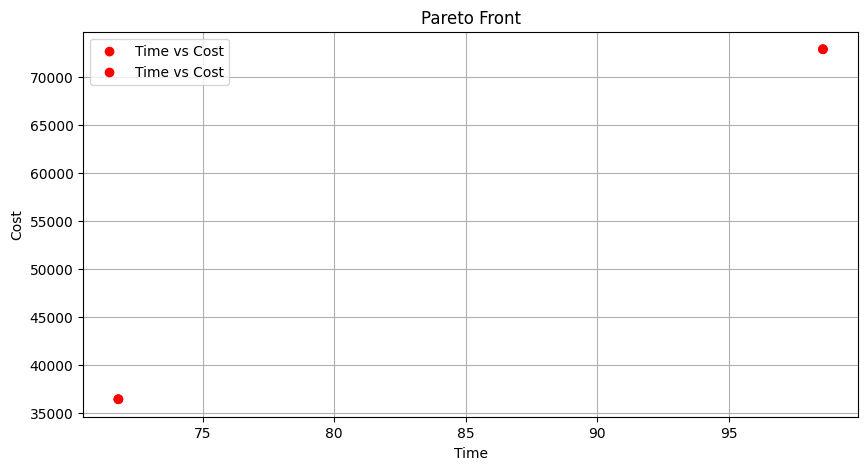

In [3]:
from docplex.mp.model import Model
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import distance_matrix as dm
import pandas as pd
import os

TARGET_WEEKDAY = 0  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
TARGET_HOUR = 8  # 0 = 00:00, 1 = 01:00, ..., 23 = 23:00

load_dotenv()

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

matrix_time_first_tw, matrix_distance = dm.main(TARGET_WEEKDAY, TARGET_HOUR, api_key)
matrix_time_second_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 1, api_key
)
matrix_time_third_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 2, api_key
)
matrix_time_fourth_tw, matrix_distance = dm.main(
    TARGET_WEEKDAY, TARGET_HOUR + 3, api_key
)

print(matrix_time_first_tw)
print("\n\n")
print(matrix_time_second_tw)
print("\n\n")
print(matrix_time_third_tw)
print("\n\n")
print(matrix_time_fourth_tw)
print("\n\n")
print(matrix_distance)

# sava datas in a matrix of matrixes
first_data = matrix_time_first_tw
second_data = matrix_time_second_tw
third_data = matrix_time_third_tw
fourth_data = matrix_time_fourth_tw

data = [first_data, second_data, third_data, fourth_data]

# parameters for time model
c = 4  # number of nodes
d = [8, 9, 10, 11]  # time intervals
tw = [[8, 12], [8, 12], [8, 12], [8, 12]]  # time windows
v = 1  # number of vehicles
q = [0, 10, 10, -10, 20]  # quantity of goods to collect/deliver
Q = 100  # maximum capacity of the vehicle
t_mv = 0.5  # time to move one item in/out from a vehicle [min]
M = 100000  # big M
tot_q = 0  # total quantity of goods to collect/delivery
del_q = 0  # quantity of goods to deliver

# parameters for energy model
distances = matrix_distance  # should match value of c
print(distances)
A = [(i, j) for i in range(c) for j in range(c) if i != j]
N0 = list(range(1, c))  # Nodi clienti (escluso il deposito)
L = 100  # Capacità massima della batteria
a = {(i, j): 2 for (i, j) in A}  # Consumo base per arco
b = {(i, j): 0.5 for (i, j) in A}  # Consumo dipendente dal carico
c_E = 1  # Costo per unità di energia consumata
c_F = 1  # Costo fisso per veicolo
c_M = 1  # Costo per unità di distanza

unused_vehicle = False

for good in q:
    tot_q += abs(good)

tot_t_mv = tot_q * t_mv

print("Total time required to collect/deliver all goods:", tot_t_mv, "minutes")

for good in q:
    if good < 0:
        del_q += good
del_q = abs(del_q)


# Define the range of values for v
v_values = range(1, 3)  # Example: from 1 to 10 vehicles

# Lists to store the results
costs = []
times = []
colors = []

print(
    "\n\n--------------------------------------------------------------------------------------------------\n\n"
)

for v in v_values:

    print(f"Computing for {v} vehicles")

    # define model
    mdl = Model("CVRP")

    # decision variables

    x = mdl.binary_var_dict(
        (
            (i, j, t, k)
            for i in range(c)
            for j in range(c)
            for t in range(len(d) - 1)
            for k in range(v)
        ),
        name="x",
    )  # x == 1 if it is true that we are going from node i to node j at time t with vehicle k
    T = mdl.continuous_var_matrix(
        c + 1, v, name="t"
    )  # arrival time at node i for vehicle k
    C = mdl.continuous_var_matrix(
        c, v, name="C"
    )  # quantity of goods when you leave node i for vehicle k

    # nodes constraints
    for k in range(v):
        mdl.add_constraint(
            mdl.sum(
                mdl.sum(x[0, j, t, k] for j in range(1, c)) for t in range(len(d) - 1)
            )
            == 1  # TO CHANGE FROM ==(it was a test to make boot vehicle works) to <=
        )  # every vehicle must leave the depot exactly once, hence every vehicle is expoloited

    for k in range(v):
        mdl.add_constraint(
            mdl.sum(
                mdl.sum(x[j, 0, t, k] for j in range(1, c)) for t in range(len(d) - 1)
            )
            == 1
        )  # every vehicle must return to the depot exactly once

    for j in range(1, c):
        mdl.add_constraint(
            mdl.sum(
                mdl.sum(
                    mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                    for t in range(len(d) - 1)
                )
                for k in range(v)
            )
            == 1
        )  # every node must be visited exactly once

    for k in range(v):
        for j in range(1, c):
            mdl.add_constraint(
                mdl.sum(
                    mdl.sum(x[i, j, t, k] for i in range(c) if i != j)
                    for t in range(len(d) - 1)
                )
                == mdl.sum(
                    mdl.sum(x[j, i, t, k] for i in range(c) if i != j)
                    for t in range(len(d) - 1)
                )
            )  # when you visit a node you ought to leave it

    # time
    for k in range(v):
        for t in range(len(d) - 1):
            mdl.add_constraint(
                T[0, k] >= d[t] * 60 * mdl.sum(x[0, j, t, k] for j in range(1, c))
            )  # when you leave depot at a time t, you ought to leave it at that time

    for k in range(v):
        for t in range(len(d) - 1):
            for j in range(1, c):
                mdl.add_constraint(
                    T[j, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for i in range(1, c))
                )  # when you arrive at a node j from node i at time t, you ought to arrive at that time

    for k in range(v):
        for t in range(len(d) - 1):
            for j in range(1, c):
                mdl.add_constraint(
                    T[j, k]
                    <= d[t + 1] * 60
                    + (1 - mdl.sum(x[i, j, t, k] for i in range(1, c))) * M
                )  # when arrive in j from i at time t, you ought to reach it before the end of the time interval

    for k in range(v):
        for t in range(len(d) - 1):
            for i in range(1, c):
                mdl.add_constraint(
                    T[i, k] >= d[t] * 60 * mdl.sum(x[i, j, t, k] for j in range(0, c))
                )  # when you arrive at node j from node i at time t, you ought to depart in that time interval

    for k in range(v):
        for t in range(len(d) - 1):
            for i in range(1, c):
                mdl.add_constraint(
                    T[i, k]
                    <= d[t + 1] * 60
                    + (1 - mdl.sum(x[i, j, t, k] for j in range(0, c))) * M
                )  # when you arrive in j from i at time t, you ought to depart from i after the start of that time interval

    for k in range(v):
        for i in range(c):
            for j in range(1, c):
                for t in range(len(d) - 1):
                    if i != j:
                        mdl.add_constraint(
                            (1 - x[i, j, t, k]) * M + T[j, k] - T[i, k]
                            >= data[t][i][j] + t_mv * abs(q[j])
                        )
                        mdl.add_constraint(
                            (1 - x[i, j, t, k]) * M - T[j, k] + T[i, k]
                            >= -data[t][i][j] - t_mv * abs(q[j])
                        )  # if you go from i to j, then the difference between the arrival time at j and i should be the same as the time required to go from i to j
                        # plus the time to load/unload the required goods

    for k in range(v):
        for t in range(len(d) - 1):
            for i in range(1, c):
                mdl.add_constraint(
                    (1 - x[i, 0, t, k]) * M + T[c, k] - T[i, k] >= data[t][i][0]
                )
                mdl.add_constraint(
                    (1 - x[i, 0, t, k]) * M - T[c, k] + T[i, k] >= -data[t][i][0]
                )  # if you go from i to the depot, then the difference between the arrival time at the depot and i should be the same as the time required to go
                # from i to the depot

    for k in range(v):
        for i in range(1, c):
            mdl.add_constraint(
                tw[i - 1][0] * 60 <= T[i, k]
            )  # you must arrive in i on-time (based on client side) lowest limit
            mdl.add_constraint(
                T[i, k] <= tw[i - 1][1] * 60
            )  # you must arrive in i on-time (based on client side) upper limit

    for k in range(v):
        mdl.add_constraint(
            T[c, k] - T[0, k] <= 8 * 60
        )  # you must return to the depot within 8 hours (a shift)

    # quantity constraints
    for k in range(v):
        for t in range(len(d) - 1):
            for i in range(c):
                for j in range(1, c):
                    if i != j:
                        mdl.add_constraint(
                            C[i, k] - C[j, k] + q[j] <= (1 - x[i, j, t, k]) * M
                        )
                        mdl.add_constraint(
                            C[j, k] - C[i, k] - q[j] <= (1 - x[i, j, t, k]) * M
                        )  # if you go from i to j, then the difference between the quantity of goods at i and j should be the same as the quantity
                        # of goods to deliver at j

    for k in range(v):
        for i in range(c):
            mdl.add_constraint(
                max(0, q[i]) <= C[i, k]
            )  # if node i requires to load goods, you must leave i with at least the quantity of goods to collect
            mdl.add_constraint(
                C[i, k] <= min(Q, Q + q[i])
            )  # you must leave i with at most Q+q[i] goods if you have to deliver at node i goods or Q if you have to collect goods at node i

    for k in range(v):
        del_qi = 0
        for j in range(1, c):
            if q[j] < 0:
                del_qi += q[j] * mdl.sum(
                    mdl.sum(x[i, j, t, k] for i in range(c)) for t in range(len(d) - 1)
                )
        mdl.add_constraint(
            C[0, k] >= -del_qi
        )  # each vehicle must depart from the depot with at least the quantity of goods to deliver for its route

    # objective function
    mdl.minimize(
        mdl.sum(
            mdl.sum(
                mdl.sum(
                    mdl.sum(x[i, j, t, k] * data[t][i][j] for i in range(c))
                    for j in range(c)
                )
                for t in range(len(d) - 1)
            )
            for k in range(v)
        )
    )  # minimize time of routes

    sol = mdl.solve()

    if sol is None:
        print("No solution found")

    print("\n\n\nTotal time required is:")

    print(sol.objective_value)

    print(sol.objective_value + tot_t_mv)

    print("\n\n\n")

    times.append(sol.objective_value + tot_t_mv)

    for k in range(v):
        print(f"\nVehicle {k}:\n")
        for t in range(len(d) - 1):
            for row in range(c):
                for col in range(c):
                    if row == 0 and sol.get_value(x[row, col, t, k]) == 1:
                        route = [(t, row, sol.get_value(T[row, k]))]
                        capacity = [(row, sol.get_value(C[row, k]))]
                        route.append((t, col, sol.get_value(T[col, k])))
                        capacity.append((col, sol.get_value(C[col, k])))
                    elif col == 0 and sol.get_value(x[row, col, t, k]) == 1:
                        end = (t, col, sol.get_value(T[c, k]))
                    elif sol.get_value(x[row, col, t, k]) == 1:
                        route.append((t, col, sol.get_value(T[col, k])))
                        capacity.append((col, sol.get_value(C[col, k])))
        route.append(end)

        print(
            " -> ".join(
                f"{node} (arrivo: {arrival:.2f} , range temporale:{t})"
                for t, node, arrival in route
            )
        )

        print("\nCapacity for each node in order of visit:")
        for node, cap in capacity:
            print(f"Node {node}: {cap:.2f}")

    # Creazione del modello

    mdl_energy = Model("EnergyOptimization")

    # Variabili di decisione

    x_energy = mdl_energy.binary_var_cube(
        len(distances), len(distances), v, name="x"
    )  # Percorsi

    f = mdl_energy.continuous_var_cube(
        len(distances), len(distances), v, name="f"
    )  # Flussi di carico

    w = mdl_energy.continuous_var_list(v, name="w")  # Consumo massimo di energia

    # Funzione obiettivo: Minimizzare i costi energetici

    mdl_energy.minimize(
        mdl_energy.sum(
            [
                mdl_energy.sum(
                    [c_F * x_energy[0, j, k] for j in range(1, len(distances))]
                )
                + mdl_energy.sum([c_M * distances[i][j] for i, j in A])
                + c_E * w[k]
                for k in range(v)
            ]
        )
    )

    # Vincoli

    for k in range(v):

        mdl_energy.add_constraint(mdl_energy.sum(x_energy[0, j, k] for j in N0) <= 1)

    for i in N0:

        mdl_energy.add_constraint(
            mdl_energy.sum(
                x_energy[i, j, k]
                for k in range(v)
                for j in range(len(distances))
                if j != i
            )
            == 1
        )

    for i in range(len(distances)):

        for k in range(v):

            mdl_energy.add_constraint(
                mdl_energy.sum(
                    x_energy[j, i, k] for j in range(len(distances)) if j != i
                )
                == mdl_energy.sum(
                    x_energy[i, j, k] for j in range(len(distances)) if j != i
                )
            )

    for i, j in A:

        for k in range(v):

            mdl_energy.add_constraint(q[j] * x_energy[i, j, k] <= f[i, j, k])

            mdl_energy.add_constraint(f[i, j, k] <= (Q - q[i]) * x_energy[i, j, k])

    for i in N0:

        mdl_energy.add_constraint(
            mdl_energy.sum(
                f[j, i, k] for k in range(v) for j in range(len(distances)) if j != i
            )
            - mdl_energy.sum(
                f[i, j, k] for k in range(v) for j in range(len(distances)) if j != i
            )
            == q[i]
        )

    for k in range(v):

        mdl_energy.add_constraint(
            mdl_energy.sum(
                a[i, j] * x_energy[i, j, k] + b[i, j] * f[i, j, k] for i, j in A
            )
            <= w[k]
        )

    for k in range(v):

        mdl_energy.add_constraint(0 <= w[k])

        mdl_energy.add_constraint(w[k] <= L)

    # Risoluzione del modello

    solution = mdl_energy.solve(log_output=False)

    cost = solution.objective_value

    costs.append(cost)

    if solution is None:

        print("Il modello non ha soluzione")

    else:

        print("Costo totale:", solution.objective_value)

        for k in range(v):

            print(
                f"Consumo massimo del veicolo {k}: {solution.get_value(mdl_energy.get_var_by_name(f'w_{k}'))}"
            )

    w = solution.get_values(w)

    for w in w:

        if w == 0:
            unused_vehicle = True

            print("\nEsistono uno o più veicoli che non vengono utilizzati")

            break

    if unused_vehicle:
        colors.append("red")
    else:
        colors.append("green")

    unused_vehicle = False


print(times)
print(costs)
print(colors)

# Plot the results to visualize the Pareto front
plt.figure(figsize=(10, 5))

# Plot the results as points in a plane
for color in colors:
    plt.scatter(times, costs, c=colors, label="Time vs Cost")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.title("Pareto Front")
plt.legend()
plt.grid(True)
plt.show()